# Project 3: Web APIs & Classification

### Contents

- [Problem Statement](#Problem-Statement)
- [Functions](#Functions)
- [Importing](#Importing)


- [Inspect Data](#Inspect-Data)
- [Clean Data](#Clean-Data)
- [Output Clean Data](#Output-Clean-Data)


- [EDA](#EDA)


- [Create Feature Matrix and Target](#Create-Feature-Matrix-and-Target)



- [Output Model Predictions](#Output-Model-Predictions)


- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Configurations and Libraries

In [1]:
# user configuration

# True: scape data from website -> save as json files
# False: load json files
scape_data = False

# scape data for subreddits[0] if scape_data=True
scape_index = 0
# scape data for subreddits[1] if scape_data=True
#scape_index = 1

num_requests = 50
posts_limit = 900

subreddits = ['boardgames','mobilegames']
url = "https://www.reddit.com/r/"
headers = {'User-agent':'Bleep blorp bot 0.1'}

features = 'title'
#features = 'selftext'

In [2]:
# import libraries

# maths
import scipy.stats as stats
import numpy as np
import pandas as pd
#from pandas.api.types import is_numeric_dtype

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score
from sklearn.pipeline import make_pipeline

# nlp
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# web
import requests
import json
from IPython.display import Image
from IPython.core.display import HTML

# others
import time
import datetime as dt
import re
import os

In [3]:
# file paths

input_path = '../data/input/'
mid_path = '../data/mid/'
output_path = '../data/output/'

image_path = '../images/'

### Functions

In [4]:
# output scaped data to json files
def write_json_files(data):    
    
    timestamp = dt.datetime.now()
    timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S")
    
    filepath = input_path + subreddits[scape_index] + '/'
    filename = subreddits[scape_index] + timestamp + '.json'
    
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    
    file = open(filepath + filename,"w+")    
    json.dump(data,file)
    
    print('created',filename)

In [5]:
# create posts list from json files
def read_json_files(subreddit):   
    
    files = []    
    filepath = input_path + subreddit

    # r=root, d=directories, f = files
    for r, d, f in os.walk(filepath):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
                
    posts = []

    # load in newer jsons first
    for f in files[::-1]:
        print(f)
        file_data = open(f).read()
        json_data = json.loads(file_data)

        posts.extend(json_data['data']['children'])
        after = json_data['data']['after']
        
    return posts

In [6]:
# created df with posts

def create_df(posts,df):

    for idx,p in enumerate(posts):

        p_keys = p['data'].keys()

        for col in cols:

            if col in p_keys:
                df.at[idx,col] = p['data'][col]
            else:
                df.at[idx,col] = np.nan
                print(idx,col,'nan')
                
    return df

### Scape or Import Data

In [10]:
# get json_data with multiple requests

if scape_data == True:

    posts = []
    after = None

    for i in range(1,num_requests+1):

        if after == None:
            params = {}
        else:
            params = {'after':after}

        json_url = url + subreddits[scape_index] + '.json'
        response = requests.get(json_url,params=params,headers=headers)

        if response.status_code == 200:       

            print('process request',i)

            json_data = response.json()
            posts.extend(json_data['data']['children'])
            after = json_data['data']['after']

            # save scaped data to files
            write_json_files(json_data)        

        else:
            print(response.status_code)
            break

        time.sleep(2)

In [11]:
# load json data from files (saved previously in input folder)

if scape_data == False:
    
    posts_a = read_json_files(subreddits[0])
    posts_b = read_json_files(subreddits[1])      

../data/input/boardgames\boardgames 2019_07_19 21_42_59.json
../data/input/boardgames\boardgames 2019_07_19 21_42_56.json
../data/input/boardgames\boardgames 2019_07_19 21_42_53.json
../data/input/boardgames\boardgames 2019_07_19 21_42_50.json
../data/input/boardgames\boardgames 2019_07_19 21_42_48.json
../data/input/boardgames\boardgames 2019_07_19 21_42_45.json
../data/input/boardgames\boardgames 2019_07_19 21_42_42.json
../data/input/boardgames\boardgames 2019_07_19 21_42_39.json
../data/input/boardgames\boardgames 2019_07_19 21_42_36.json
../data/input/boardgames\boardgames 2019_07_19 21_42_32.json
../data/input/boardgames\boardgames 2019_07_19 21_42_29.json
../data/input/boardgames\boardgames 2019_07_19 21_42_27.json
../data/input/boardgames\boardgames 2019_07_19 21_42_24.json
../data/input/boardgames\boardgames 2019_07_19 21_42_21.json
../data/input/boardgames\boardgames 2019_07_19 21_42_18.json
../data/input/boardgames\boardgames 2019_07_19 21_42_15.json
../data/input/boardgames

In [12]:
# posts count info

if scape_data == False:
    
    total_posts_a = len(posts_a)
    unique_posts_a = len(set(p['data']['name'] for p in posts_a))
    total_posts_b = len(posts_b)
    unique_post_b = len(set(p['data']['name'] for p in posts_b))
    
    print('total number of posts:',total_posts_a)
    print('unique number of posts:',unique_posts_a)
    print('')
    print('total number of posts:',total_posts_b)
    print('unique number of posts:',unique_post_b)

total number of posts: 2235
unique number of posts: 1165

total number of posts: 2204
unique number of posts: 956


### Inspect Data

In [13]:
# print some info from posts_a (subreddit[0])

# for p in posts_a:
    
#     title = p['data']['title']
#     #subreddit = p['data']['subreddit']
#     score = p['data']['score']
#     pinned = p['data']['pinned'] 
    
#     print(title)
#     print(subreddit)
#     print(score)
#     print(pinned)
#     print('')
    
#     keys = p['data'].keys()    
#     print(len(keys))   

In [14]:
# create empty df

#cols = list(posts_a[0]['data'].keys())
cols = ['name','title','score','selftext']

df = pd.DataFrame(columns=cols)
df_a = pd.DataFrame(columns=cols)
df_b = pd.DataFrame(columns=cols)

In [15]:
# convert posts to df

df_a = create_df(posts_a,df_a)
df_b = create_df(posts_b,df_b)

In [16]:
# drop rows with empty selftext

# need to check for empty string in selftext???
if False:

    print(len(df_a))
    print(len(df_b))

    df_a['selftext'].replace('',np.nan,inplace=True)
    df_b['selftext'].replace('',np.nan,inplace=True)

    df_a.dropna(subset=['selftext'],inplace=True)
    df_b.dropna(subset=['selftext'],inplace=True)

    print(len(df_a))
    print(len(df_b))

In [17]:
# remove rows with duplicated name

print(len(df_a))
print(len(df_b))

df_a.drop_duplicates(subset='name',inplace=True)
df_b.drop_duplicates(subset='name',inplace=True)

print(len(df_a))
print(len(df_b))

2235
2204
1165
956


In [18]:
df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [19]:
df_a['selftext'].apply(len).sort_values(ascending=True)

495         0
361         0
944         0
904         0
138         0
139         0
639         0
339         0
640         0
336         0
777         0
778         0
709         0
328         0
162         0
790         0
642         0
547         0
634         0
936         0
1434        0
368         0
1444        0
393         0
1442        0
391         0
94          0
97          0
98          0
551         0
        ...  
1352     4880
276      5077
236      5402
798      5594
52       5596
396      5952
522      6261
323      6542
506      6545
420      7006
605      7067
1357     7215
504      7566
491      7586
583      7773
312      7928
42       8129
916      8507
647      8771
157      9212
341     11174
839     11663
654     12309
536     12548
927     13138
723     15055
1273    19660
55      21592
741     24697
430     32425
Name: selftext, Length: 1165, dtype: int64

In [20]:
# list all columns

print(df_a.columns)

Index(['name', 'title', 'score', 'selftext'], dtype='object')


In [21]:
# output 1st 5 records

df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [22]:
# df_a summary

df_a_desc = df_a.describe()
df_a_desc

,name,title,score,selftext
count,1165,1165,1165,1165
unique,1165,1165,202,987
top,t3_cetq3y,Does anyone know what the 29th pic down game i...,0,
freq,1,1,76,137


In [23]:
# Check for nulls in columns

null_cols = df_a.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [24]:
# Check for nulls in rows

null_rows = df_a.isnull().sum(axis=1)
mask_null = null_rows > 0
null_rows[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [25]:
# show column summary

df_a_info = df_a.info()
df_a_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 0 to 2178
Data columns (total 4 columns):
name        1165 non-null object
title       1165 non-null object
score       1165 non-null object
selftext    1165 non-null object
dtypes: object(4)
memory usage: 45.5+ KB


In [26]:
# limit no of rows in each df

df_a = df_a[:posts_limit]
df_b = df_b[:posts_limit]

### Clean Data

In [27]:
# rename columns

In [28]:
# convert all string in cells to lowercase -> prevent duplicates when creating dummies

#df_train = df_train.applymap(lambda s:s.lower() if type(s) == str else s)
#df_test = df_test.applymap(lambda s:s.lower() if type(s) == str else s)

In [29]:
# fill nan/empty cells with na

#cols = ['pool_qual','bsmt_qual','fireplace_score','garage_qual','garage_cond','bsmt_type1_score','bsmt_type2_score']

#for col in cols:
    #df_train[col] = df_train[col].fillna(value='na')
    #df_test[col] = df_test[col].fillna(value='na')

In [30]:
# # fill nan/empty cells with 0

# cols = ['bath_half_bsmt_num','bath_full_bsmt_num','garage_area','garage_car_num','bsmt_total_area',
#         'bsmt_unfinish_area','bsmt_type2_area','bsmt_type1_area']

# for col in cols:
#     df_train[col] = df_train[col].fillna(value='0')
#     df_test[col] = df_test[col].fillna(value='0')

### Output Clean Data

In [31]:
# output to csv

#df_a.to_csv(mid_path + 'df_a.csv')

### EDA

In [32]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_a[features])

len_features = len(cvec.get_feature_names())
print(len_features)

df_a_cv = pd.DataFrame(cvec.transform(df_a[features]).todense(),columns=cvec.get_feature_names())

top_a = df_a_cv.sum(axis=0)
top_a.sort_values(ascending = False).head(20)

2111


game               249
board              114
games               94
2019                55
play                41
question            40
july                38
help                31
new                 31
card                30
boardgames          29
discussion          25
kickstarter         25
player              25
table               23
recommendations     22
best                22
review              21
comc                21
daily               21
dtype: int64

In [33]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_b[features])

len_features = len(cvec.get_feature_names())
print(len_features)

df_b_cv = pd.DataFrame(cvec.transform(df_b[features]).todense(),columns=cvec.get_feature_names())

top_b = df_b_cv.sum(axis=0)
top_b.sort_values(ascending = False).head(20)

1933


game        334
mobile      204
games       103
android     101
new          73
ios          65
play         63
gameplay     52
like         39
looking      38
best         36
good         35
free         28
help         26
2018         24
amp          22
look         22
heroes       20
review       20
pubg         20
dtype: int64

In [34]:
# get top words in df_a

df_top_a = top_a.to_frame(name='count')
df_top_a['word'] = df_top_a.index
df_top_a.reset_index(drop=True, inplace=True)
df_top_a['freq'] = df_top_a['count'] / len(df_a) * 100

cols = ['word','count','freq']
df_top_a = df_top_a[cols]
df_top_a.sort_values(by='count',ascending=False, inplace=True)
df_top_a.head(10)

,word,count,freq
799,game,249,27.666667
247,board,114,12.666667
805,games,94,10.444444
35,2019,55,6.111111
1364,play,41,4.555556
1478,question,40,4.444444
1008,july,38,4.222222
877,help,31,3.444444
1237,new,31,3.444444
319,card,30,3.333333


In [35]:
# get top words in df_b

df_top_b = top_b.to_frame(name='count')
df_top_b['word'] = df_top_b.index
df_top_b.reset_index(drop=True, inplace=True)
df_top_b['freq'] = df_top_b['count'] / len(df_b) * 100

cols = ['word','count','freq']
df_top_b = df_top_b[cols]
df_top_b.sort_values(by='count',ascending=False, inplace=True)
df_top_b.head(10)

,word,count,freq
708,game,334,37.111111
1116,mobile,204,22.666667
714,games,103,11.444444
96,android,101,11.222222
1166,new,73,8.111111
918,ios,65,7.222222
1277,play,63,7.000000
711,gameplay,52,5.777778
1001,like,39,4.333333
1022,looking,38,4.222222


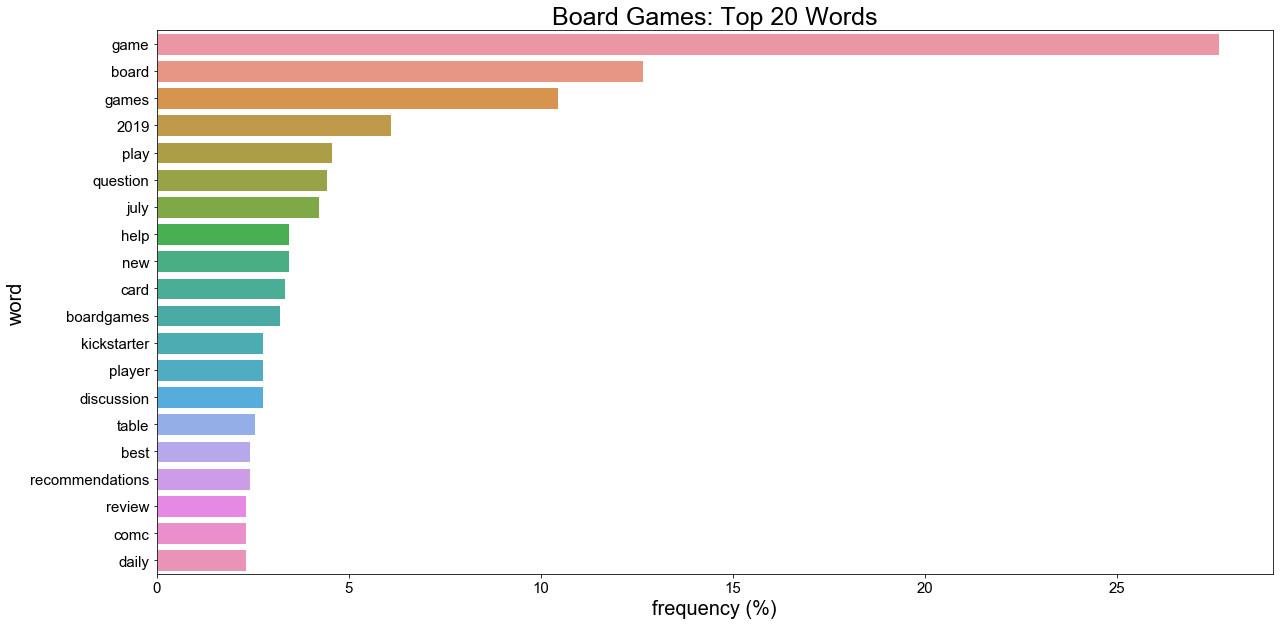

In [36]:
plt.figure(figsize=(20,10))
plt.title('Board Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_a.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

#boardgames Daily Discussion and Game Recommendations (July 17, 2019)'

'\nHey guys! We are a husband &amp; wife game dev team &amp; we are weeks away from launching our first game! \nWe cant wait to share our journey with you! \nGame will be for android and ios! \nIts an arcade style maze runner game and it is so fun! \n(Not to toot our own horn but - toot toot)\n'

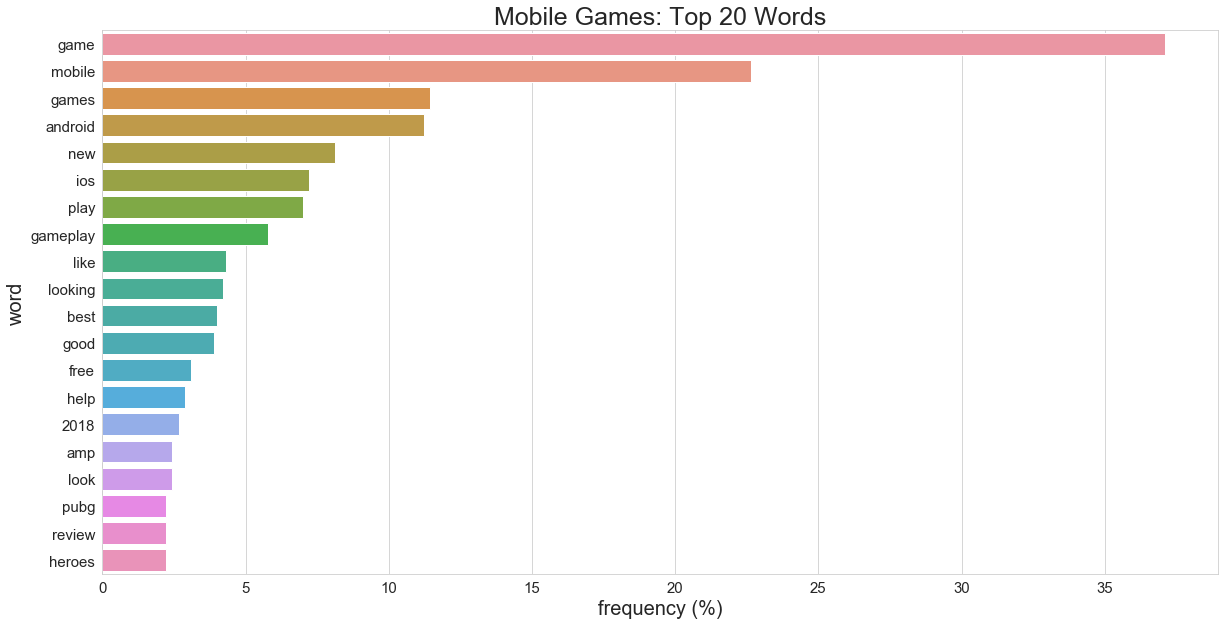

In [37]:
plt.figure(figsize=(20,10))
plt.title('Mobile Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_b.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

'''
Hey guys! We are a husband &amp; wife game dev team &amp; we are weeks away from launching our first game! 
We cant wait to share our journey with you! 
Game will be for android and ios! 
Its an arcade style maze runner game and it is so fun! 
(Not to toot our own horn but - toot toot)
'''

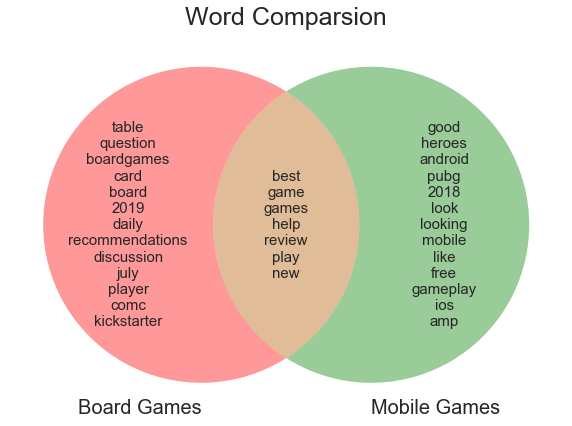

In [38]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df_top_a['word'][:20])
set_b = set(df_top_b['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Board Games','Mobile Games'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(15)
venn.get_label_by_id('110').set_size(15)
venn.get_label_by_id('010').set_size(15)

### Logistic Regression Model

In [39]:
df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [40]:
df_b.head()

,name,title,score,selftext
0,t3_bbdq7o,"Age Of Z, recruiting",1,I'm looking for players who play the game age ...
1,t3_bbb1np,There was a java game...,1,"I remember playing an old game on my nokia, ab..."
2,t3_bb4yj9,Mmorpg?,1,Hi guys! Can you suggest some mobile mmorpg? S...
3,t3_bar748,The worst mobile game ad I have ever seen,1,
4,t3_baqg2e,Searching for games to be transplanted from st...,1,"Hi, I am a steam game player with more than 30..."


In [41]:
# create df by appending df_a and df_b

df = df.append(df_a)
df = df.append(df_b)

df.reset_index(drop=True,inplace=True)

In [42]:
# create target (use one hot encoding)

df['is_a'] = 0
df['is_a'].iloc[0:len(df_a)] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
# create X (feature matrix) and y (target)

X = df[[features]]
#X = pd.DataFrame(columns=[features])
#X[features] = df[features]

y = df['is_a'].values

In [44]:
# init WordNetLemmatizer and stopword
# apply lemmatization on feature selected

if True:

    wnl = WordNetLemmatizer()
    ps = PorterStemmer()
    #stopword = set(stopwords.words('english'))    

    for idx,row in X.iterrows():
        words = re.sub('[^a-zA-Z]',' ',row[features])
        words = words.split()

        words_2 = []

        for word in words:

            word_2 = word.lower()  

            #if word_2 not in stopword:

            word_2 = ps.stem(word) 
            #word_2 = wnl.lemmatize(word_2, pos="v")
            words_2.append(word_2)

        output = ' '.join(words_2)

        X.at[idx,features] = output    

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,stratify=y,random_state=3050)

In [46]:
# check train and test data

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1260, 1)
(540, 1)
(1260,)
(540,)


In [47]:
# use CountVectorizer

cvec = CountVectorizer(stop_words='english')
cvec.fit(X_train[features])

len_features = len(cvec.get_feature_names())
print(len_features)

X_train_cv = pd.DataFrame(cvec.transform(X_train[features]).todense(),columns=cvec.get_feature_names())
X_test_cv = pd.DataFrame(cvec.transform(X_test[features]).todense(),columns=cvec.get_feature_names())

2266


In [48]:
# use LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_cv,y_train)

lr_score = lr.score(X_test_cv, y_test)
print(lr_score)

0.8555555555555555


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Bayes Classifer

In [49]:
# create MultinomialNB model
mnb = MultinomialNB()

mnb.fit(X_train_cv,y_train)
y_pred = mnb.predict(X_test_cv)

In [50]:
# score MultinomialNB model

train_score = mnb.score(X_train_cv,y_train)
print(train_score)

test_score = mnb.score(X_test_cv,y_test)
print(test_score)

0.9619047619047619
0.8777777777777778


In [51]:
# create confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)

True Positives: 231
False Positives: 27
False Negatives: 39
True Negatives: 243


In [52]:
# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

Accuracy: 0.878
Sensitivity: 0.856
Specificity: 0.9
Precision: 0.895


### Models by Pipeline

In [91]:
# TfidfVectorizer with LogisticRegression

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                     ngram_range=(1,2)),
                      LogisticRegression(),
                      )

model.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.8518518518518519
Number of features: 1000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
model.steps[0][1].get_feature_names()

['absolut smitten ani',
 'addict game android',
 'amp new thi',
 'amp review tl',
 'android mobil game',
 'ani board game',
 'ani idea game',
 'anyon ani idea',
 'anyon els notic',
 'anyon know ani',
 'anyon know thi',
 'anyon play game',
 'arena combat cach',
 'armi dark defens',
 'assassin shoot kill',
 'avail io android',
 'best android game',
 'best mobil game',
 'betray hous hill',
 'board game card',
 'board game play',
 'board game tabl',
 'boardgam daili discuss',
 'brick breaker quest',
 'combat cach pack',
 'comc collect year',
 'comc year hobbi',
 'daili discuss game',
 'develop diari werewolf',
 'diari werewolf vs',
 'did play thi',
 'discuss game recommend',
 'doe anyon know',
 'doe anyon rememb',
 'dragon hack everyon',
 'dragon nest sea',
 'end soon includ',
 'favorit board game',
 'final fantasi tactic',
 'food chain magnat',
 'forc multiplay onlin',
 'free play mobil',
 'game focu group',
 'game io android',
 'game like thi',
 'game look like',
 'game play review',
 'g

In [90]:
# TfidfVectorizer with MultinomialNB

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                      ngram_range=(1,2)),
                      MultinomialNB()
                      )

model.fit(X_train[features], y_train)
y_pred = model.predict(X_test[features])

print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

0.8555555555555555
Number of features: 1000


### Output Model Predictions

In [55]:
# output to csv

#timestamp = dt.datetime.now()
#timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S ")
    
# contains selected columns for feature matrix
#df_cols.to_csv(output_path + 'columns' + timestamp + '.csv')

### Descriptive and Inferential Statistics

In [56]:
df_top_a_cv = df_a_cv[list(set_a)]
df_top_b_cv = df_b_cv[list(set_b)]

# for each post, count number of occurances (from top words list)
a_cv_has_top = df_top_a_cv.sum(axis=1)
b_cv_has_top = df_top_b_cv.sum(axis=1)

In [57]:
# create df_a_cv_has_top

df_a_cv_has_top= a_cv_has_top.value_counts().to_frame()

df_a_cv_has_top['occurances'] = df_a_cv_has_top.index

df_a_cv_has_top.reset_index(drop=True, inplace=True)

df_a_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_a_cv_has_top['freq'] = df_a_cv_has_top["num_posts"] / len(df_a) * 100
cols = ['occurances','num_posts','freq']
df_a_cv_has_top = df_a_cv_has_top[cols]

In [58]:
# create df_b_cv_has_top

df_b_cv_has_top= b_cv_has_top.value_counts().to_frame()

df_b_cv_has_top['occurances'] = df_b_cv_has_top.index

df_b_cv_has_top.reset_index(drop=True, inplace=True)

df_b_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_b_cv_has_top['freq'] = df_b_cv_has_top["num_posts"] / len(df_b) * 100
cols = ['occurances','num_posts','freq']
df_b_cv_has_top = df_b_cv_has_top[cols]

In [61]:
df_a_cv_has_top

,occurances,num_posts,freq
0,0,375,41.666667
1,1,285,31.666667
2,2,147,16.333333
3,3,57,6.333333
4,7,18,2.000000
5,4,12,1.333333
6,6,3,0.333333
7,5,3,0.333333


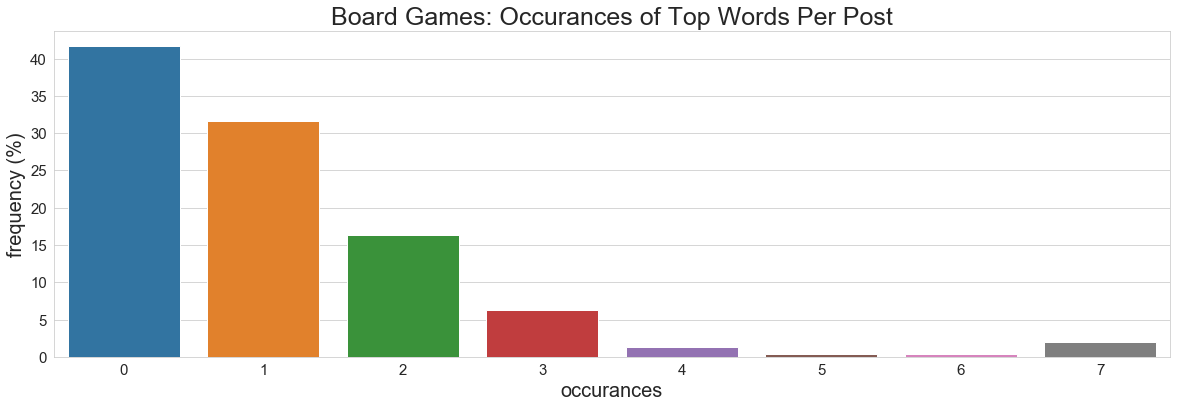

In [59]:
plt.figure(figsize=(20,6))
plt.title('Board Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_a_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

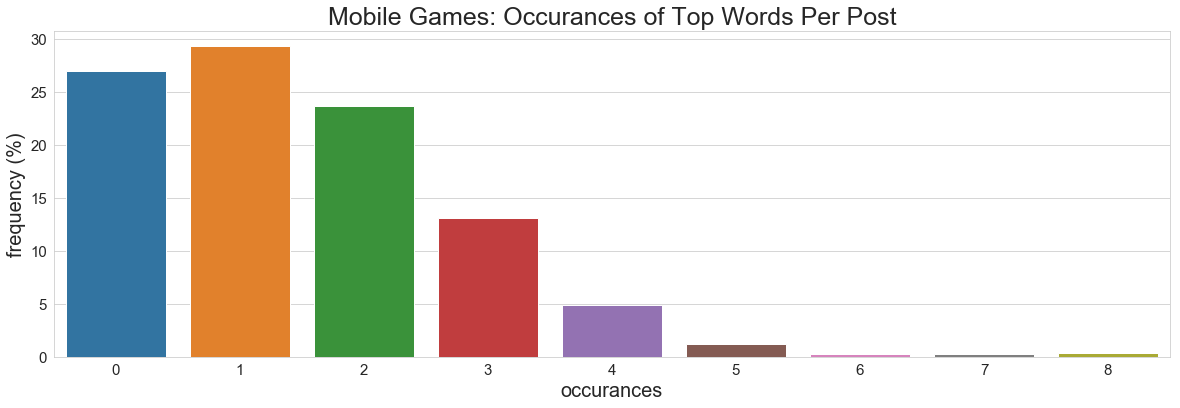

In [60]:
plt.figure(figsize=(20,6))
plt.title('Mobile Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_b_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

### Outside Research

### Conclusions and Recommendations